# Figure 3

In [2]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from pathlib import Path
from glob import glob
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [3]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data = glass_data.drop(['corrcoef'], axis=1)
glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

# further control the dataset so that all aspect ratio in glass can fall into the range of ITO's ratio
ito_ratio_min = ito_data['ratio'].min()
ito_ratio_max = ito_data['ratio'].max()

glass_data = glass_data[(glass_data['ratio'] > ito_ratio_min) & (glass_data['ratio'] < ito_ratio_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# further control the dataset so that all width and length in glass can fal into the range of ITO's
ito_width_min = ito_data['width'].min()
ito_width_max = ito_data['width'].max()
ito_length_min = ito_data['length'].min()
ito_length_max = ito_data['length'].max()

glass_data = glass_data[(glass_data['width'] > ito_width_min) & (glass_data['width'] < ito_width_max)]
glass_data = glass_data[(glass_data['length'] > ito_length_min) & (glass_data['length'] < ito_length_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# Randomly sample 1000 rows from each dataframe
glass_data = glass_data.sample(n=1000, random_state=42)
glass_data = glass_data.reset_index(drop=True)
ito_data = ito_data.sample(n=1000, random_state=42)
ito_data = ito_data.reset_index(drop=True)
print(glass_data.shape)

(1205, 7)
(1179, 7)
(1000, 7)


In [4]:
# define testing data from actual experiments
exp_glass_data = pd.read_csv(Path(p, '100323_ZJ_exp_glass_final.csv'))
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)

# create the specific number of data
exp_glass_data = exp_glass_data.sample(50, random_state=42)
exp_ito_data = exp_ito_data.sample(50, random_state=42)

X_exp_glass = exp_glass_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
yw_exp_glass = exp_glass_data['width']
yl_exp_glass = exp_glass_data['length']

X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
yw_exp_ito = exp_ito_data['width']
yl_exp_ito = exp_ito_data['length']

In [5]:
def analytical_method(glass_data, target_n):
    l_d = 0.37 * glass_data['volume']**(1/3)
    term1 = (glass_data['width'] + l_d) / (glass_data['width'] + 2*l_d)
    # term2 = l_d / (glass_data['width'] + 2*l_d)
    
    # Constants
    omega_p = 9  # plasma frequency in eV
    epsilon_inf = 9.84  # high-frequency dielectric constant
    n_glass = 1.52  # effective refractive index for glass substrate
    aspect_ratio = glass_data['ratio']  # given aspect ratio
    n_X = target_n  # refractive index for unknown substrate

    alpha = term1
    n_med = 1.0
    n_eff_glass = alpha*n_med + n_glass*(1-alpha)
    n_eff_X = alpha*n_med + n_X*(1-alpha)

    # Depolarization factor L for the given aspect ratio
    L = (1 + aspect_ratio)**-1.6

    # Resonance energy for glass substrate
    E_res_glass = omega_p / np.sqrt(n_eff_glass**2 / L + epsilon_inf - n_eff_glass**2)

    # Resonance energy for unknown substrate
    E_res_X = omega_p / np.sqrt(n_eff_X**2 / L + epsilon_inf - n_eff_X**2)

    # Calculate the factor F
    F = E_res_X / E_res_glass
    
    return F

In [6]:
glass_data = glass_data.sample(1000, random_state=42)
# define input and output
X_glass = glass_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = glass_data['width']
yl_glass = glass_data['length']

ito_data = ito_data.sample(1000, random_state=42)
# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']

F_ITO = analytical_method(glass_data, target_n=1.96)

## Figure3A

In [7]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 21)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred0 = gsw.predict(X_exp_glass)

rel_errw0 = (abs(yw_exp_glass-yw_pred0)/yw_exp_glass)*100
rmspew0 = (sum(rel_errw0**2)/len(yw_pred0)) ** 0.5
maew0 = mean_absolute_error(yw_exp_glass, yw_pred0)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred0 = gsl.predict(X_exp_glass)

rel_errl0 = (abs(yl_exp_glass-yl_pred0)/yl_exp_glass)*100
rmspel0 = (sum(rel_errl0**2)/len(yl_pred0)) ** 0.5
mael0 = mean_absolute_error(yl_exp_glass, yl_pred0)

print(rmspew0, rmspel0)
print(maew0, mael0)

11.687637265760978 12.844017340175224
2.864159047619047 10.377692730158726


## Figure3B

In [8]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 21)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred1 = gsw.predict(X_exp_ito)

rel_errw1 = (abs(yw_exp_ito-yw_pred1)/yw_exp_ito)*100
rmspew1 = (sum(rel_errw1**2)/len(yw_pred1)) ** 0.5
maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred1 = gsl.predict(X_exp_ito)

rel_errl1 = (abs(yl_exp_ito-yl_pred1)/yl_exp_ito)*100
rmspel1 = (sum(rel_errl1**2)/len(yl_pred1)) ** 0.5
mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)

print(rmspew1, rmspel1)
print(maew1, mael1)

12.164364336807326 13.740119031810991
3.0494564476961705 10.754903100768512


## Figure3C

In [9]:
X_glass['eres'] = X_glass['eres']*F_ITO

In [10]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 21)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred2 = gsw.predict(X_exp_ito)

rel_errw2 = (abs(yw_exp_ito-yw_pred2)/yw_exp_ito)*100
rmspew2 = (sum(rel_errw2**2)/len(yw_pred2)) ** 0.5
maew2 = mean_absolute_error(yw_exp_ito, yw_pred2)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred2 = gsl.predict(X_exp_ito)

rel_errl2 = (abs(yl_exp_ito-yl_pred2)/yl_exp_ito)*100
rmspel2 = (sum(rel_errl2**2)/len(yl_pred2)) ** 0.5
mael2 = mean_absolute_error(yl_exp_ito, yl_pred2)

print(rmspew2, rmspel2)
print(maew2, mael2)

14.614964597107713 9.421831087533885
3.867992773892774 6.888973395976575


## Figure3D

In [11]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 21)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_ito, yw_ito)
yw_pred3 = gsw.predict(X_exp_ito)

rel_errw3 = (abs(yw_exp_ito-yw_pred3)/yw_exp_ito)*100
rmspew3 = (sum(rel_errw3**2)/len(yw_pred3)) ** 0.5
maew3 = mean_absolute_error(yw_exp_ito, yw_pred3)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_ito, yl_ito)
yl_pred3 = gsl.predict(X_exp_ito)

rel_errl3 = (abs(yl_exp_ito-yl_pred3)/yl_exp_ito)*100
rmspel3 = (sum(rel_errl3**2)/len(yl_pred1)) ** 0.5
mael3 = mean_absolute_error(yl_exp_ito, yl_pred3)

print(rmspew3, rmspel3)
print(maew3, mael3)

12.147329985624054 7.89308271711928
3.1192692077922084 5.4432740000000015


C:\Users\katsuya2\AppData\Local\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\katsuya2\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


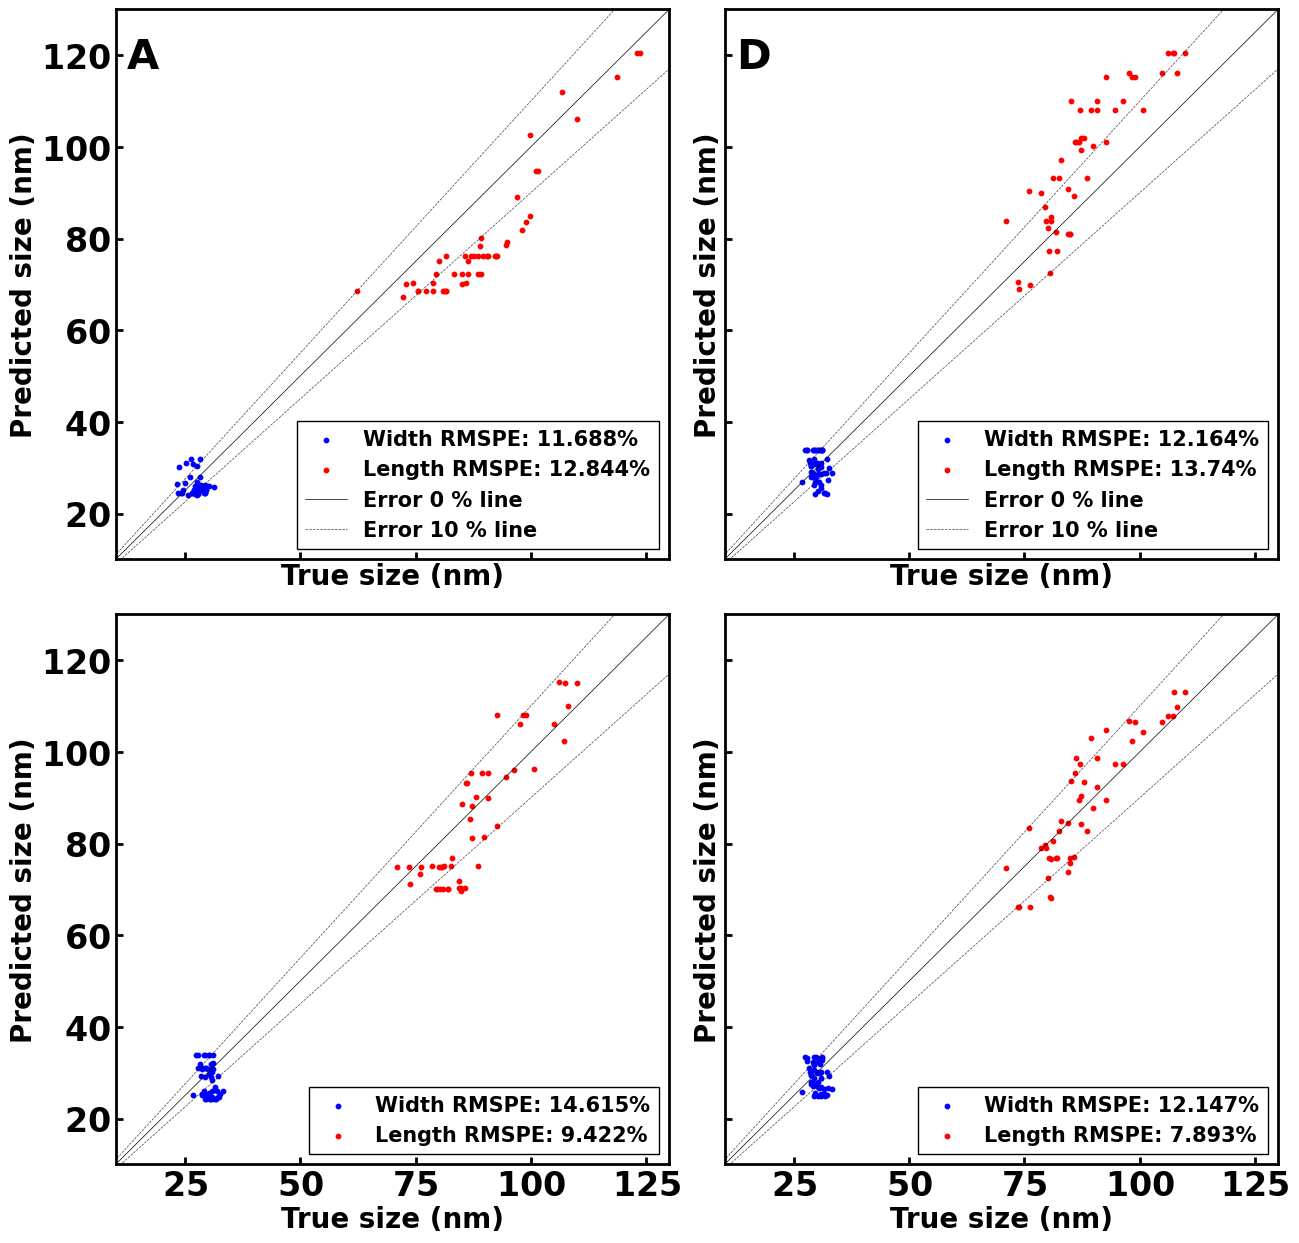

In [12]:
# Create a figure with two subplots, sharing the x-axis
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

axs[0, 0].scatter(yw_exp_glass, yw_pred0, s=10, c='b', label=f'Width RMSPE: {round(rmspew0, 3)}%')
axs[0, 0].scatter(yl_exp_glass, yl_pred0, s=10, c='r', label=f'Length RMSPE: {round(rmspel0, 3)}%')

x = np.arange(-1, 181)
axs[0, 0].plot(x, x, c='k', lw=0.5, label='Error 0 % line')
axs[0, 0].plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
axs[0, 0].plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

axs[0, 0].set_xlabel('True size (nm)')
axs[0, 0].set_ylabel('Predicted size (nm)')
axs[0, 0].set_xlim(10, 130)
axs[0, 0].set_ylim(10, 130)
axs[0, 0].legend(loc='lower right', fontsize=15)
axs[0, 0].text(0.02, 0.95, 'A', ha='left', va='top', transform=axs[0, 0].transAxes, fontsize=30)

axs[0, 1].scatter(yw_exp_ito, yw_pred1, s=10, c='b', label=f'Width RMSPE: {round(rmspew1, 3)}%')
axs[0, 1].scatter(yl_exp_ito, yl_pred1, s=10, c='r', label=f'Length RMSPE: {round(rmspel1, 3)}%')

x = np.arange(-1, 181)
axs[0, 1].plot(x, x, c='k', lw=0.5, label='Error 0 % line')
axs[0, 1].plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
axs[0, 1].plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

axs[0, 1].set_xlabel('True size (nm)')
axs[0, 1].set_ylabel('Predicted size (nm)')
axs[0, 1].set_xlim(10, 130)
axs[0, 1].set_ylim(10, 130)
axs[0, 1].legend(loc='lower right', fontsize=15)
axs[0, 1].text(0.02, 0.95, 'C', ha='left', va='top', transform=axs[1, 0].transAxes, fontsize=30)


axs[1, 0].scatter(yw_exp_ito, yw_pred2, s=10, c='b', label=f'Width RMSPE: {round(rmspew2, 3)}%')
axs[1, 0].scatter(yl_exp_ito, yl_pred2, s=10, c='r', label=f'Length RMSPE: {round(rmspel2, 3)}%')

axs[1, 0].plot(x, x, c='k', lw=0.5)
axs[1, 0].plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, alpha=0.75)
axs[1, 0].plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

axs[1, 0].set_xlabel('True size (nm)')
axs[1, 0].set_ylabel('Predicted size (nm)')
axs[1, 0].set_xlim(10, 130)
axs[1, 0].set_ylim(10, 130)
axs[1, 0].legend(loc='lower right', fontsize=15)
axs[1, 0].text(0.02, 0.95, 'D', ha='left', va='top', transform=axs[1, 1].transAxes, fontsize=30)


axs[1, 1].scatter(yw_exp_ito, yw_pred3, s=10, c='b', label=f'Width RMSPE: {round(rmspew3, 3)}%')
axs[1, 1].scatter(yl_exp_ito, yl_pred3, s=10, c='r', label=f'Length RMSPE: {round(rmspel3, 3)}%')

axs[1, 1].plot(x, x, c='k', lw=0.5)
axs[1, 1].plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, alpha=0.75)
axs[1, 1].plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

axs[1, 1].set_xlabel('True size (nm)')
axs[1, 1].set_ylabel('Predicted size (nm)')
axs[1, 1].set_xlim(10, 130)
axs[1, 1].set_ylim(10, 130)
axs[1, 1].legend(loc='lower right', fontsize=15)
axs[1, 1].text(0.02, 0.95, 'D', ha='left', va='top', transform=axs[0, 1].transAxes, fontsize=30)


plt.subplots_adjust(hspace=0)  # Remove the space between plots